<a href="https://colab.research.google.com/github/Akshitwadhwa/Stock-modelling/blob/main/Time_series_Stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This is the third colab notebook made for selecting the stocks using MPT and making optimal portfolios based upon them

###1.1 This is the notebook which cotains the time series of portfolio returns.We have taken the same nifty 50 stocks for this


### **1.2 What is Time Series**
Time series analysis involves the study of the collected data point which were recorded over time.
In financial terms is is also know as the historical price and the performace data of the financial assests.


In [ ]:
## Firstly we are going to import the neccesary libraries which are
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import cvxpy as cp
import random



## 2. Time seires and it realtion with MPT

-- Time series plays a crucial role in making an optimal portfolio as the data given by the time series is crucial in calculating the optimal returns as well as the expected returns for each asset.

-- Time series analysis allows investors to compute correlation coefficients between different assets.

-- Time series models (ARIMA, LSTM, etc.) are used to forecast returns or volatility.

In [ ]:
# Step 1: Collect Data
nifty50_stocks = [
    "RELIANCE.NS", "TCS.NS", "INFY.NS", "HDFCBANK.NS", "ICICIBANK.NS", "KOTAKBANK.NS",
    "HINDUNILVR.NS", "SBIN.NS", "LT.NS", "ITC.NS", "AXISBANK.NS", "BAJFINANCE.NS",
    "ASIANPAINT.NS", "MARUTI.NS", "SUNPHARMA.NS", "ULTRACEMCO.NS", "NESTLEIND.NS", "WIPRO.NS",
    "NTPC.NS", "POWERGRID.NS", "COALINDIA.NS", "TITAN.NS", "TECHM.NS", "GRASIM.NS",
    "BHARTIARTL.NS", "HCLTECH.NS", "DRREDDY.NS", "ADANIENT.NS", "BAJAJFINSV.NS", "TATASTEEL.NS",
    "HDFCLIFE.NS", "SBILIFE.NS", "HEROMOTOCO.NS", "DIVISLAB.NS", "INDUSINDBK.NS", "JSWSTEEL.NS",
    "CIPLA.NS", "EICHERMOT.NS", "UPL.NS", "BPCL.NS", "BRITANNIA.NS", "SHREECEM.NS",
    "ONGC.NS", "APOLLOHOSP.NS", "BAJAJ-AUTO.NS", "M&M.NS", "HINDALCO.NS", "TATACONSUM.NS",
    "TATAMOTORS.NS", "SBICARD.NS"
]

In [ ]:
price_data = yf.download(nifty50_stocks, start="2010-01-01", end="2024-01-01")

[*********************100%***********************]  50 of 50 completed


In [ ]:

if 'Adj Close' in price_data:
    price_data = price_data['Adj Close']
elif 'Close' in price_data:
    price_data = price_data['Close']
else:
    raise ValueError("Neither 'Adj Close' nor 'Close' columns are available in the downloaded data.")


price_data = price_data.dropna(axis=1, thresh=len(price_data) * 0.9)
returns = price_data.pct_change().dropna()

mean_returns = returns.mean()
cov_matrix = returns.cov()

# Step 3: Generate All Combinations of 6 Stocks
combinations_of_stocks = list(combinations(returns.columns, 6))

# this time we have takeing the random stocks and applied no measure in selecting the 6 stocks


<ipython-input-35-d09530b0fb1b>:10: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = price_data.pct_change().dropna()


### 2. This time we have taken random stocks rather than applying some metrics upon it.


Best Portfolio:
Stocks: ('ADANIENT.NS', 'APOLLOHOSP.NS', 'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJAJFINSV.NS', 'BRITANNIA.NS')
Weights: [0.07499683 0.12428694 0.22197778 0.         0.18105737 0.39768107]
Expected Return: 0.0011660396809517548
Volatility: 0.012153520759070354
Sharpe Ratio: 0.09594254241772056


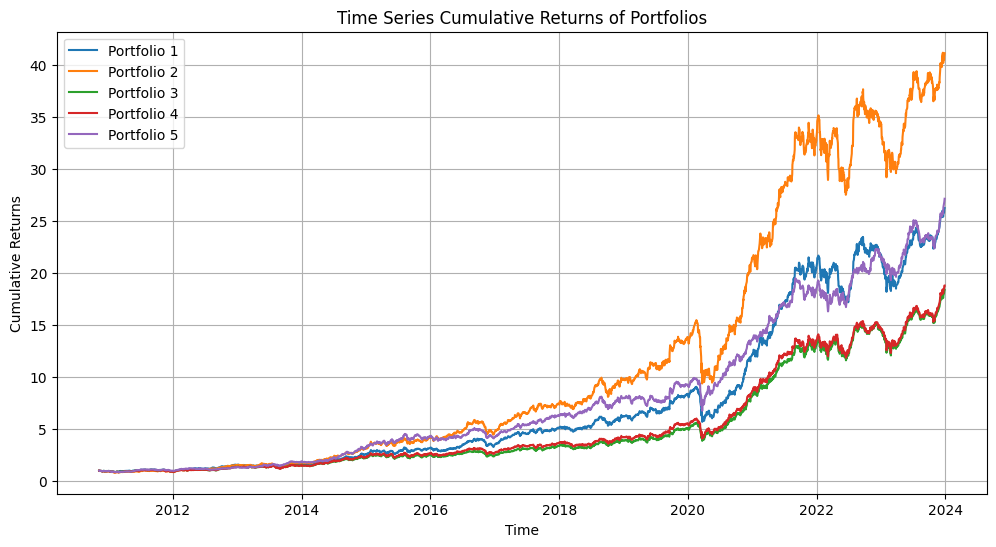

In [ ]:

# Step 4: Optimize Portfolio Metrics
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

def sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
    portfolio_return, portfolio_volatility = portfolio_performance(weights, mean_returns, cov_matrix)
    return (portfolio_return - risk_free_rate) / portfolio_volatility

def optimize_portfolio(stocks):
    mean_ret = mean_returns[list(stocks)]
    cov_mat = cov_matrix.loc[list(stocks), list(stocks)]
    num_stocks = len(stocks)
    init_guess = num_stocks * [1. / num_stocks]  # Equal weights initially
    bounds = tuple((0, 1) for _ in range(num_stocks))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights sum to 1

    def neg_sharpe(weights):
        return -sharpe_ratio(weights, mean_ret, cov_mat)

    result = minimize(neg_sharpe, init_guess, bounds=bounds, constraints=constraints)
    return result.x, portfolio_performance(result.x, mean_ret, cov_mat)

# Step 5: Evaluate Portfolios
portfolio_results = []

for stocks in combinations_of_stocks[:50]:  # Analyze the first 50 combinations for efficiency
    try:
        weights, (exp_return, volatility) = optimize_portfolio(stocks)
        sharpe = sharpe_ratio(weights, mean_returns[list(stocks)], cov_matrix.loc[list(stocks), list(stocks)])
        portfolio_results.append({
            'Stocks': stocks,
            'Weights': weights,
            'Expected Return': exp_return,
            'Volatility': volatility,
            'Sharpe Ratio': sharpe
        })
    except Exception as e:
        print(f"Optimization failed for {stocks}: {e}")

# Step 6: Select the Best Portfolio
if not portfolio_results:
    raise ValueError("No valid portfolios found. Please check the data and optimization steps.")

best_portfolio = max(portfolio_results, key=lambda x: x['Sharpe Ratio'])

# Display Best Portfolio
print("\nBest Portfolio:")
print(f"Stocks: {best_portfolio['Stocks']}")
print(f"Weights: {best_portfolio['Weights']}")
print(f"Expected Return: {best_portfolio['Expected Return']}")
print(f"Volatility: {best_portfolio['Volatility']}")
print(f"Sharpe Ratio: {best_portfolio['Sharpe Ratio']}")

# Step 8: Time Series Cumulative Returns
cumulative_returns = pd.DataFrame()

for i, pf in enumerate(portfolio_results[:5]):  # Compute for the first 5 portfolios as an example
    stocks = pf['Stocks']
    weights = pf['Weights']

    portfolio_returns = (returns[list(stocks)] * weights).sum(axis=1)
    cum_returns = (1 + portfolio_returns).cumprod()
    cumulative_returns[f'Portfolio {i + 1}'] = cum_returns

plt.figure(figsize=(12, 6))
for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=column)

plt.title("Time Series Cumulative Returns of Portfolios")
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid()
plt.show()

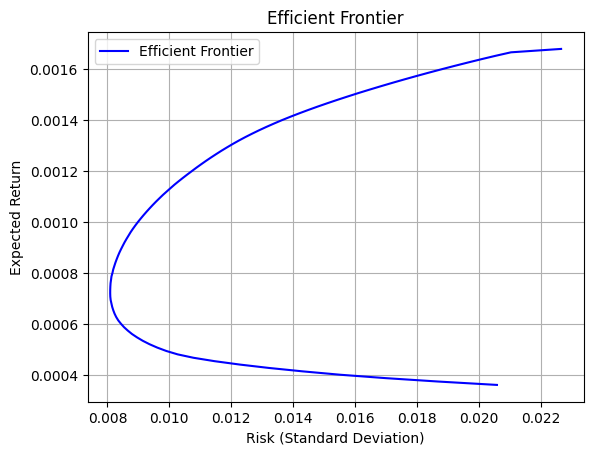

In [ ]:
def plot_efficient_frontier(mean_returns, cov_matrix):
    target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 100)
    risks = []

    for target in target_returns:
        def minimize_volatility(weights):
            return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

        constraints = [
            {'type': 'eq', 'fun': lambda x: np.dot(x, mean_returns) - target},
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        ]
        bounds = [(0, 1)] * len(mean_returns)
        init_guess = [1 / len(mean_returns)] * len(mean_returns)

        result = minimize(minimize_volatility, init_guess, bounds=bounds, constraints=constraints)
        risks.append(result.fun)

    plt.plot(risks, target_returns, label="Efficient Frontier", color='blue')
    plt.xlabel("Risk (Standard Deviation)")
    plt.ylabel("Expected Return")
    plt.title("Efficient Frontier")
    plt.grid()
    plt.legend()
    plt.show()

plot_efficient_frontier(mean_returns, cov_matrix)


In [ ]:
mean_returns = returns.mean()
cov_matrix = returns.cov()


## 2.1 These mean returns tells in helping in analyzing and forcasting the data points orders over a period of time.

In [ ]:
mean_returns.head(5)

,0
Ticker,
ADANIENT.NS,0.001614
APOLLOHOSP.NS,0.000979
ASIANPAINT.NS,0.000947
AXISBANK.NS,0.000664
BAJAJ-AUTO.NS,0.000682
